In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 8.8MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620900 sha256=4e030070165aa59143d5ce4f043a31b7036a32fd5c1a414b59eb6920a7d9e2f9
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=8ddddfb94d9468821570e0ad297f3daf7876a5a347df3e95181ed4cd68a4c991
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [ ]:
import numpy as np
import sys
import random
from pycuda import compiler, gpuarray, tools
import pycuda.driver as drv
import pycuda.autoinit
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# number of polynomial params in each individual:
N = 3
BLOCK_SIZE = 16

In [ ]:
def generate_first_population(count_parents):
    return np.array([random.uniform(-1, 1) for i in range(count_parents * N)])


In [ ]:
def fitness(count, count_ind, children):
    fat_err, h = 0.0, 2 * np.pi / count
    arr_ind = []

    for i in range(count_ind):
        for j in range(count):
            err = 0.0
            for k in range(N):
                X = (j * h + h) ** k
                err += children[i * N + k] * X

            fat_err += (np.sin(j * h + h) - err) ** 2

        arr_ind.append(fat_err)
        fat_err = 0.0
    return arr_ind


In [ ]:
def select_best_parents(arr, count_individuals, count_parents, children):
    indexes = [0] * count_parents
    arr_min = []
    bp = [None] * N * count_parents

    for p in range(count_parents):
        arr_min.append(sys.float_info.max)

    for i in range(count_individuals):
        if arr[i] < arr_min[0]:
            arr_min[0] = arr[i]
            indexes[0] = i

    for p in range(1, count_parents):
        for i in range(count_individuals):
            if arr[i] > arr_min[p - 1] and arr[i] < arr_min[p]:
                arr_min[p] = arr[i]
                indexes[p] = i

    for i in range(count_parents):
        for j in range(N):
            indexes[i] * N
            bp[i * N + j] = children[indexes[i] * N + j]

    return indexes, np.array(bp)


In [ ]:
kernel_code = """
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <curand_kernel.h>

extern "C"
    {
    #define CURAND_CALL ( x ) do { if (( x ) != CURAND_STATUS_SUCCESS ) {\
    printf (" Error at % s :% d \ n " , __FILE__ , __LINE__ ) ;\
    return EXIT_FAILURE ;}} while (0)
 __global__ void Breeding_GPU(int Em, int Dm, int count, int countInd, double* d_bP, int N, double* d_childrens) {

  int countParents = 10;
	int index = blockIdx.x * blockDim.x + threadIdx.x;
	int stride = blockDim.x * gridDim.x;

	if(index < countParents){
		for (int i = index; i < countParents; i += stride) {
			int countChildren = countInd / countParents;
			for (int j = 0; j < countChildren; j++) {

				curandState state;
				curand_init((unsigned long long)clock() + index, 0, 0, &state);

				int n = floor(curand_uniform_double(&state) * N);

				for (int k = 0; k < n; k++) {
					d_childrens[i * countChildren * N + j * N + k] = d_bP[i * N + k];
				}

				for (int k = n; k < N; k++) {
					d_childrens[i * countChildren * N + j * N + k] = d_bP[(countParents - i) * N + k];
				}
				curand_init((unsigned long long)clock() + index, 0, 0, &state);

				if (curand_uniform_double(&state) > 0.5) {

					double d = Dm * curand_uniform_double(&state);
					double m = Em;
					if (curand_uniform_double(&state) > 0.5)
						m += d;
					else
						m -= d;
					int nn = (int)(curand_uniform_double(&state) * N);
					if (curand_uniform_double(&state) > 0.5)
						d_childrens[i * countChildren * N + j * N + nn] += m;
					else
						d_childrens[i * countChildren * N + j * N + nn] -= m;
				}
			}
		}
	}		
}
}
"""

In [ ]:
# compile the kernel code
mod = compiler.SourceModule(kernel_code, keep=False, no_extern_c=True)

# get the kernel function from the compiled module
Breeding_GPU = mod.get_function("Breeding_GPU")


In [ ]:
def plot_epochs_graph(epochs):
  x = [i[0] for i in epochs]
  y = [i[1] for i in epochs] 
  plt.plot(x, y)
  plt.show()

1000
1000
1
4
10
100
100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in add
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in square
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


min:  [1018.75433] epoch:  8
[4.74962e-40] *x^ 0 +  [0.85527503] *x^ 1 +  [-0.15142743] *x^ 2 GPU_time:  9.812812998916343e-05


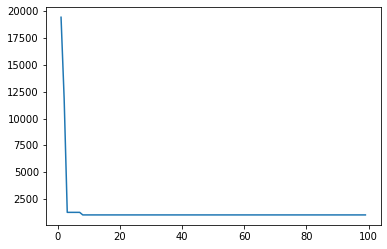

In [ ]:
print("Enter count of points (500 - 1000):")
count = int(input())

print("Enter count of individuals (1000 - 2000):")
count_ind = int(input())

print("Enter mean for Mutation:")
Em = float(input())

print("Enter varience for Mutation:")
Dm = float(input())

print("Enter count pair of parents:")
count_parents = int(input())

count_parents *= 2

print("# Enter maximal count of epochs:")
max_iter = int(input())

print("# Enter maximal count of epochs with same results:")
max_const_iter = int(input())

best_parents = generate_first_population(count_parents)

min, val = sys.float_info.max, sys.float_info.max

ind_best, same_iter = 1, 1

sum_time_gpu = 0

grid = (count_parents * count_ind, 1)

epochs = []

for epoch in range(1, max_iter):
    # time begin
   # children = make_children(best_parents, count_parents, count_ind, Em, Dm)
    best_parents_gpu = gpuarray.to_gpu(best_parents)

    children_gpu = gpuarray.empty((count_ind * N, 1), np.float32)

    start_gpu = timer()
    Breeding_GPU(
        #inputs:
        np.int32(Em), np.int32(Dm), np.int32(count), np.int32(count_ind), best_parents_gpu, np.int32(N),
        #output:
        children_gpu,
        #grid:
        grid=grid,
        #block:
        block=(BLOCK_SIZE, 1, 1)
    )
    sum_time_gpu += timer() - start_gpu

    children = children_gpu.get()
    arr_ind = fitness(count, count_ind, children)
    indexes, best_parents = select_best_parents(arr_ind, count_ind, count_parents, children)

    #print("Epoch ", epoch, ": ", arr_ind[indexes[0]])
    epochs.append([epoch, arr_ind[indexes[0]]])
    
    if arr_ind[indexes[0]] < min:
        min = arr_ind[indexes[0]]
        ind_best = epoch

    if val == arr_ind[indexes[0]]:
        same_iter += 1

    else:
        val = arr_ind[indexes[0]]
        same_iter = 1

    if same_iter >= max_const_iter:
        print("Same ", max_const_iter, " iterations")

print("min: ", min, "epoch: ", ind_best)

for j in range(N):
    print(best_parents[j], "*x^", j, end=' ')
    if j + 1 < N:
        print("+ ", end=' ')

print("GPU_time: ", sum_time_gpu/max_iter) 
plot_epochs_graph(epochs)